## Импорт библиотек

In [384]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from mlxtend.classifier import StackingCVClassifier
from catboost import CatBoostClassifier
import itertools
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import f1_score

In [271]:
import os
os.chdir(r"C:\..\..\..\data")

## Контр-пики героев

In [405]:
dfs = []

for i in range(1,18): 
    df_part = pd.read_csv(f'dota2dataset{i}.csv')
    dfs.append(df_part)

df = pd.concat(dfs, ignore_index=True).drop_duplicates().reset_index(drop=True)

In [ ]:
df.to_csv(r'dota2dataset.csv')

In [273]:
df['Result'] = (df['Result'] == df['Team_Radiant']).astype(int)

In [274]:
df = df.drop(['Team_Radiant', 'Team_Dire', 'DateTime'], axis=1)

In [275]:
all_hero_cols = ['Hero_Rad_1', 'Hero_Rad_2', 'Hero_Rad_3', 'Hero_Rad_4', 'Hero_Rad_5',
                'Hero_Dire_1', 'Hero_Dire_2', 'Hero_Dire_3', 'Hero_Dire_4', 'Hero_Dire_5']
all_heroes = df[all_hero_cols].values.flatten()
all_heroes = pd.unique(all_heroes)
all_heroes = [h for h in all_heroes.flatten() if h is not np.nan]
x=itertools.combinations(all_heroes, 2)

In [276]:
df.shape

(59508, 11)

In [277]:
df['radiant'] = df[['Hero_Rad_1', 'Hero_Rad_2', 'Hero_Rad_3', 'Hero_Rad_4', 'Hero_Rad_5']].values.tolist()
df['dire'] = df[['Hero_Dire_1', 'Hero_Dire_2', 'Hero_Dire_3', 'Hero_Dire_4', 'Hero_Dire_5']].values.tolist()

In [278]:
df = df.drop(['Hero_Rad_1', 'Hero_Rad_2', 'Hero_Rad_3', 'Hero_Rad_4', 'Hero_Rad_5', 
              'Hero_Dire_1', 'Hero_Dire_2', 'Hero_Dire_3', 'Hero_Dire_4', 'Hero_Dire_5'], axis=1)
X = df

In [279]:
X

,Result,radiant,dire
0,1,"[Sven, Marci, Enigma, Jakiro, Storm Spirit]","[Rubick, Chen, Axe, Dark Willow, Broodmother]"
1,0,"[Morphling, Centaur Warrunner, Enchantress, Ho...","[Pangolier, Phoenix, Bane, Broodmother, Alchem..."
2,1,"[Templar Assassin, Elder Titan, Weaver, Troll ...","[Invoker, Beastmaster, Phoenix, Nyx Assassin, ..."
3,0,"[Dark Seer, Clockwerk, Hoodwink, Sven, Sand King]","[Invoker, Ogre Magi, Dark Willow, Underlord, C..."
4,0,"[Pangolier, Hoodwink, Warlock, Alchemist, Sand...","[Storm Spirit, Snapfire, Dragon Knight, Brewma..."
...,...,...,...
59503,1,"[Pangolier, Templar Assassin, Crystal Maiden, ...","[Sand King, Shadow Fiend, Weaver, Night Stalke..."
59504,1,"[Venomancer, Windranger, Tusk, Terrorblade, Pr...","[Slark, Enchantress, Tiny, Beastmaster, Zeus]"
59505,1,"[Ursa, Void Spirit, Disruptor, Dark Willow, Da...","[Batrider, Phoenix, Skywrath Mage, Wraith King..."
59506,0,"[Witch Doctor, Elder Titan, Shadow Fiend, Medu...","[Storm Spirit, Phoenix, Tiny, Sven, Invoker]"


In [280]:
radiant_win=X[X["Result"]==1]
dire_win=X[X["Result"]==0]

In [281]:
dict1={}
for i in x:
    dict1[i]={"Win":0, "Total":0}

In [282]:
for index, row in radiant_win.iterrows():
    rad = row.iloc[1]
    dire = row.iloc[2]
    
    for i in range(len(rad)):
        for j in range(len(dire)):
            key = (rad[i], dire[j])
            if key in dict1:
                try:
                    dict1[key]['Win'] += 1
                    dict1[key]["Total"] += 1
                except KeyError:
                    pass
            else:
                try:
                    alt_key = (dire[j], rad[i])
                    dict1[alt_key]["Total"] += 1
                except KeyError:
                    pass

In [283]:
for index, row in dire_win.iterrows():
    rad = row.iloc[1]
    dire = row.iloc[2]
    
    for i in range (len(rad)):
        for j in range (len(dire)):
            key = (rad[i],dire[j])
            if (key in dict1):
                try:
                    dict1[key]["Total"]+=1
                except:
                    pass
            else:
                try:
                    alt_key = (dire[j],rad[i])
                    dict1[alt_key]['Win']+=1
                    dict1[alt_key]["Total"]+=1
                except:
                    pass

In [284]:
hero_pair_counter_rate=pd.DataFrame.from_dict(dict1)
new=hero_pair_counter_rate.transpose()
new.head()

Win  Total
Sven Marci         176    377
     Enigma        117    228
     Jakiro        345    686
     Storm Spirit  187    333
     Rubick        475    965

In [285]:
def counter_rate(x):
    new = x.copy()
    new['counter_rate'] = new['Win'] / new['Total']
    return new
new1=counter_rate(new)

more_than_50_matches = new1[new1['Total']>=50]

more_than_50_matches=more_than_50_matches.sort_values(by=['counter_rate'],ascending=False,)
top10 = more_than_50_matches.head(10)
top10

,,Win,Total,counter_rate
Outworld Destroyer,Tidehunter,42,52,0.807692
Dark Seer,Nature's Prophet,69,90,0.766667
Sven,Sniper,43,58,0.741379
Crystal Maiden,Lycan,43,58,0.741379
Leshrac,Tidehunter,44,60,0.733333
Lion,Nature's Prophet,44,60,0.733333
Enigma,Nature's Prophet,38,52,0.730769
Earthshaker,Mirana,43,59,0.728814
Legion Commander,Tidehunter,64,88,0.727273
Shadow Demon,Razor,64,89,0.719101


In [286]:
diff_counter=[]

for index, row in X.iterrows():
    rad = row.iloc[1]
    dire = row.iloc[2]
    status = row.iloc[0]
    
    if status == 1:
        total_counter_rate=0
        for i in range (len(rad)):
            each_hero=0
            for j in range (len(dire)):
                key = (rad[i],dire[j])
                if (key in dict1):
                    try:
                        each_hero+=(dict1[key]['Win']/dict1[key]['Total'])
                    except:
                        each_hero+=0
                else:
                    try:
                        alt_key = (dire[j],rad[i])
                        each_hero+=(dict1[alt_key]['Win']/dict1[alt_key]['Total'])
                    except:
                        pass
                        each_hero+=0
            avg_counter_rate=each_hero/5
            total_counter_rate+=avg_counter_rate
        diff = total_counter_rate/5 - (1 - (total_counter_rate/5))
        diff_counter.append(diff)
    else:
        total_counter_rate=0
        for i in range (len(dire)):
            each_hero=0
            for j in range (len(rad)):
                key = (dire[i],rad[j])
                if (key in dict1):
                    try:
                        each_hero+=(1-dict1[key]['Win']/dict1[key]['Total'])
                    except:
                        each_hero+=0
                else:
                    try:
                        alt_key = (rad[j],dire[i])
                        each_hero+=(1-dict1[alt_key]['Win']/dict1[alt_key]['Total'])
                    except:
                        pass
                        each_hero+=0
            avg_counter_rate=each_hero/5
            total_counter_rate+=avg_counter_rate
        diff = total_counter_rate/5 - (1 - (total_counter_rate/5))
        diff_counter.append(diff)

In [287]:
X['diff_counter']=diff_counter
X

,Result,radiant,dire,diff_counter
0,1,"[Sven, Marci, Enigma, Jakiro, Storm Spirit]","[Rubick, Chen, Axe, Dark Willow, Broodmother]",0.029120
1,0,"[Morphling, Centaur Warrunner, Enchantress, Ho...","[Pangolier, Phoenix, Bane, Broodmother, Alchem...",-0.009334
2,1,"[Templar Assassin, Elder Titan, Weaver, Troll ...","[Invoker, Beastmaster, Phoenix, Nyx Assassin, ...",0.027390
3,0,"[Dark Seer, Clockwerk, Hoodwink, Sven, Sand King]","[Invoker, Ogre Magi, Dark Willow, Underlord, C...",-0.033056
4,0,"[Pangolier, Hoodwink, Warlock, Alchemist, Sand...","[Storm Spirit, Snapfire, Dragon Knight, Brewma...",-0.004154
...,...,...,...,...
59503,1,"[Pangolier, Templar Assassin, Crystal Maiden, ...","[Sand King, Shadow Fiend, Weaver, Night Stalke...",-0.002670
59504,1,"[Venomancer, Windranger, Tusk, Terrorblade, Pr...","[Slark, Enchantress, Tiny, Beastmaster, Zeus]",-0.000833
59505,1,"[Ursa, Void Spirit, Disruptor, Dark Willow, Da...","[Batrider, Phoenix, Skywrath Mage, Wraith King...",0.061804
59506,0,"[Witch Doctor, Elder Titan, Shadow Fiend, Medu...","[Storm Spirit, Phoenix, Tiny, Sven, Invoker]",0.010695


In [288]:
X.to_csv(r'df_between_counter_rate1.csv')

## Синергия героев

In [289]:
dfs = []

for i in range(1,18): 
    df_part = pd.read_csv(f'dota2dataset{i}.csv')
    dfs.append(df_part)

df = pd.concat(dfs, ignore_index=True).drop_duplicates().reset_index(drop=True)

In [290]:
df['Result'] = (df['Result'] == df['Team_Radiant']).astype(int)

In [291]:
df = df.drop(['Team_Radiant', 'Team_Dire', 'DateTime'], axis=1)

In [292]:
all_hero_cols = ['Hero_Rad_1', 'Hero_Rad_2', 'Hero_Rad_3', 'Hero_Rad_4', 'Hero_Rad_5',
                'Hero_Dire_1', 'Hero_Dire_2', 'Hero_Dire_3', 'Hero_Dire_4', 'Hero_Dire_5']
all_heroes = df[all_hero_cols].values.flatten()
all_heroes = pd.unique(all_heroes)
all_heroes = [h for h in all_heroes.flatten() if h is not np.nan]
x=itertools.combinations(all_heroes, 2)

In [293]:
df['radiant'] = df[['Hero_Rad_1', 'Hero_Rad_2', 'Hero_Rad_3', 'Hero_Rad_4', 'Hero_Rad_5']].values.tolist()
df['dire'] = df[['Hero_Dire_1', 'Hero_Dire_2', 'Hero_Dire_3', 'Hero_Dire_4', 'Hero_Dire_5']].values.tolist()

In [294]:
df = df.drop(['Hero_Rad_1', 'Hero_Rad_2', 'Hero_Rad_3', 'Hero_Rad_4', 'Hero_Rad_5', 
              'Hero_Dire_1', 'Hero_Dire_2', 'Hero_Dire_3', 'Hero_Dire_4', 'Hero_Dire_5'], axis=1)

In [295]:
X = df
radiant_win=X[X["Result"]==1]
dire_win=X[X["Result"]==0]

In [296]:
dict1={}
for i in x:
    dict1[i]={"Win":0, "Total":0}

In [297]:
for i in dict1:
    count=0
    for j in radiant_win['radiant']:
        if (i[0] in j and i[1] in j):
            count+=1
    dict1[i]['Win']=count
    dict1[i]['Total']=count+dict1[i]['Total']
    
    count1=0
    for j in radiant_win['dire']:
        if (i[0] in j and i[1] in j):
            count1+=1
    dict1[i]['Total']=count1+dict1[i]['Total']

In [298]:
for i in dict1:
    count=0
    for j in dire_win['radiant']:
        if (i[0] in j and i[1] in j):
            count+=1
    dict1[i]['Total']=count+dict1[i]['Total']
    
    count1=0
    for j in dire_win['dire']:
        if (i[0] in j and i[1] in j):
            count1+=1
    dict1[i]['Win']=count1+dict1[i]['Win']
    dict1[i]['Total']=count1+dict1[i]['Total']

In [299]:
hero_pair_win_rate=pd.DataFrame.from_dict(dict1)
new=hero_pair_win_rate.transpose()
new.head()

Win  Total
Sven Marci         117    218
     Enigma        132    232
     Jakiro        227    449
     Storm Spirit  196    381
     Rubick        494    947

In [300]:
def winrate(x):
    new = x.copy()
    new['winrate'] = new['Win'] / new['Total']
    return new
new1=winrate(new)

more_than_50_matches = new1[new1['Total']>=50]

more_than_50_matches=more_than_50_matches.sort_values(by=['winrate'],ascending=False,)
top10 = more_than_50_matches.head(10)
top10

,,Win,Total,winrate
Beastmaster,Underlord,38,50,0.760000
Keeper of the Light,Winter Wyvern,43,59,0.728814
Crystal Maiden,Winter Wyvern,46,64,0.718750
Lion,Luna,39,55,0.709091
Shadow Shaman,Ancient Apparition,50,73,0.684932
Slardar,Undying,64,95,0.673684
Bounty Hunter,Winter Wyvern,72,107,0.672897
Enigma,Disruptor,43,64,0.671875
Chen,Primal Beast,36,54,0.666667
Oracle,Witch Doctor,48,72,0.666667


In [301]:
def radiant(i):
    synergy = 0
    i.sort()
    x=itertools.combinations(i, 2)
    for j in x:
        if (j[0] == 'Unknown' or j[1] == 'Unknown'):
            synergy+=0
        else:
            try:
                synergy+=dict1[j]['Win']/dict1[j]['Total']
            except:
                synergy+=dict1[j[1],j[0]]['Win']/dict1[j[1],j[0]]['Total']
    return synergy
    

X['synergy_radiant']=X['radiant'].apply(radiant)


def dire(i):
    synergy = 0
    i.sort()
    x=itertools.combinations(i, 2)
    for j in x:
        if (j[0] == 'Unknown' or j[1] == 'Unknown'):
            synergy+=0
        else:
            try:
                synergy+=dict1[j]['Win']/dict1[j]['Total']
            except:
                synergy+=dict1[j[1],j[0]]['Win']/dict1[j[1],j[0]]['Total']
    return synergy
    

X['synergy_dire']=X['dire'].apply(dire)

In [302]:
X.head()

,Result,radiant,dire,synergy_radiant,synergy_dire
0,1,"[Enigma, Jakiro, Marci, Storm Spirit, Sven]","[Axe, Broodmother, Chen, Dark Willow, Rubick]",5.383961,5.090989
1,0,"[Centaur Warrunner, Enchantress, Hoodwink, Mor...","[Alchemist, Bane, Broodmother, Pangolier, Phoe...",4.794794,4.893110
2,1,"[Elder Titan, Pangolier, Templar Assassin, Tro...","[Beastmaster, Dragon Knight, Invoker, Nyx Assa...",5.201377,4.831002
3,0,"[Clockwerk, Dark Seer, Hoodwink, Sand King, Sven]","[Chaos Knight, Dark Willow, Invoker, Ogre Magi...",5.356185,5.090211
4,0,"[Alchemist, Hoodwink, Pangolier, Sand King, Wa...","[Brewmaster, Crystal Maiden, Dragon Knight, Sn...",4.887220,5.160259


In [303]:
def difference(x):
    new_df = x.copy()
    new_df['df_between_hero_synergy'] = new_df.synergy_radiant - new_df.synergy_dire
    return new_df

new_df=difference(X)

In [304]:
new_df

,Result,radiant,dire,synergy_radiant,synergy_dire,df_between_hero_synergy
0,1,"[Enigma, Jakiro, Marci, Storm Spirit, Sven]","[Axe, Broodmother, Chen, Dark Willow, Rubick]",5.383961,5.090989,0.292972
1,0,"[Centaur Warrunner, Enchantress, Hoodwink, Mor...","[Alchemist, Bane, Broodmother, Pangolier, Phoe...",4.794794,4.893110,-0.098316
2,1,"[Elder Titan, Pangolier, Templar Assassin, Tro...","[Beastmaster, Dragon Knight, Invoker, Nyx Assa...",5.201377,4.831002,0.370375
3,0,"[Clockwerk, Dark Seer, Hoodwink, Sand King, Sven]","[Chaos Knight, Dark Willow, Invoker, Ogre Magi...",5.356185,5.090211,0.265974
4,0,"[Alchemist, Hoodwink, Pangolier, Sand King, Wa...","[Brewmaster, Crystal Maiden, Dragon Knight, Sn...",4.887220,5.160259,-0.273039
...,...,...,...,...,...,...
59503,1,"[Centaur Warrunner, Crystal Maiden, Pangolier,...","[Chen, Night Stalker, Sand King, Shadow Fiend,...",4.923868,5.173685,-0.249817
59504,1,"[Primal Beast, Terrorblade, Tusk, Venomancer, ...","[Beastmaster, Enchantress, Slark, Tiny, Zeus]",5.072052,4.946114,0.125939
59505,1,"[Dark Seer, Dark Willow, Disruptor, Ursa, Void...","[Batrider, Phoenix, Skywrath Mage, Venomancer,...",5.424662,5.147871,0.276791
59506,0,"[Dark Seer, Elder Titan, Medusa, Shadow Fiend,...","[Invoker, Phoenix, Storm Spirit, Sven, Tiny]",5.045483,5.170205,-0.124722


In [305]:
new_df.to_csv(r'df_between_hero_synergy.csv')

## Создаем финальный датасет

In [306]:
diff_counter = pd.read_csv('df_between_counter_rate1.csv')

In [307]:
final = diff_counter[['Result','diff_counter']]

In [308]:
for hero in all_heroes:
    final.loc[:, f'radiant_{hero}'] = diff_counter['radiant'].apply(lambda x: 1 if hero in x else 0)
    final.loc[:, f'dire_{hero}'] = diff_counter['dire'].apply(lambda x: 1 if hero in x else 0)

In [309]:
final['df_between_hero_synergy'] = new_df['df_between_hero_synergy']

In [313]:
final.head()

,Result,diff_counter,radiant_Sven,dire_Sven,radiant_Marci,dire_Marci,radiant_Enigma,dire_Enigma,radiant_Jakiro,dire_Jakiro,...,dire_Treant Protector,radiant_Tinker,dire_Tinker,radiant_Riki,dire_Riki,radiant_Medusa,dire_Medusa,radiant_Luna,dire_Luna,df_between_hero_synergy
0,1,0.029120,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0.292972
1,0,-0.009334,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.098316
2,1,0.027390,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.370375
3,0,-0.033056,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.265974
4,0,-0.004154,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.273039


In [311]:
final.to_csv(r'final.csv')

## Обучение моделей и предсказание

In [316]:
X_final = final.drop('Result', axis=1)
y = final['Result']

In [319]:
scaler = StandardScaler()
scaler.fit(X_final)
X_final=pd.DataFrame(scaler.transform(X_final),columns=X_final.columns)
X_final.head()

,diff_counter,radiant_Sven,dire_Sven,radiant_Marci,dire_Marci,radiant_Enigma,dire_Enigma,radiant_Jakiro,dire_Jakiro,radiant_Storm Spirit,...,dire_Treant Protector,radiant_Tinker,dire_Tinker,radiant_Riki,dire_Riki,radiant_Medusa,dire_Medusa,radiant_Luna,dire_Luna,df_between_hero_synergy
0,0.910827,4.043423,-0.24888,4.260620,-0.225641,5.478129,-0.180916,4.123766,-0.240353,3.545534,...,-0.176712,-0.11252,-0.112826,-0.09046,-0.09046,-0.092607,-0.088069,-0.111056,-0.103192,0.773156
1,-0.329916,-0.247315,-0.24888,-0.234708,-0.225641,-0.182544,-0.180916,-0.242497,-0.240353,-0.282045,...,-0.176712,-0.11252,-0.112826,-0.09046,-0.09046,-0.092607,-0.088069,-0.111056,-0.103192,-0.262435
2,0.855003,-0.247315,-0.24888,-0.234708,-0.225641,-0.182544,-0.180916,-0.242497,-0.240353,-0.282045,...,-0.176712,-0.11252,-0.112826,-0.09046,-0.09046,-0.092607,-0.088069,-0.111056,-0.103192,0.978013
3,-1.095304,4.043423,-0.24888,-0.234708,-0.225641,-0.182544,-0.180916,-0.242497,-0.240353,-0.282045,...,-0.176712,-0.11252,-0.112826,-0.09046,-0.09046,-0.092607,-0.088069,-0.111056,-0.103192,0.701704
4,-0.162774,-0.247315,-0.24888,-0.234708,-0.225641,-0.182544,-0.180916,-0.242497,-0.240353,-0.282045,...,-0.176712,-0.11252,-0.112826,-0.09046,-0.09046,-0.092607,-0.088069,-0.111056,-0.103192,-0.724859


In [325]:
kfold = model_selection.KFold(n_splits=6, random_state=17, shuffle=True)

In [333]:
c_values = np.logspace(-2, 3, 500)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=kfold, verbose=0, max_iter=10000, n_jobs=-1)
logit_searcher.fit(X_final, y)

print('Лучшие параметры:', logit_searcher.C_)

scores = cross_val_score(logit_searcher, X_final, y, cv=5, scoring='accuracy')
print('Средняя точность модели:', scores.mean())

Лучшие параметры: [0.04691835]
Средняя точность модели: 0.7642839710025229


In [334]:
logreg = LogisticRegression(C=logit_searcher.C_[0], max_iter=10000)

In [388]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={'learning_rate' : hp.uniform('learning_rate', 0.005, 0.35),
        'max_depth': hp.quniform("max_depth", 2, 10, 1),
        'gamma': hp.uniform ('gamma', 0, 1),
        'reg_alpha' : hp.uniform('reg_alpha', 0,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.uniform('min_child_weight', 1, 10),
        'n_estimators': hp.quniform('n_estimators', 200, 3000, 100),
        'subsample' : hp.uniform('subsample', 0.5, 1),
    }

In [389]:
def objective(space):
    clf = XGBClassifier(
        learning_rate=space['learning_rate'],
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=space['reg_alpha'],
        reg_lambda=space['reg_lambda'],
        colsample_bytree=space['colsample_bytree'],
        min_child_weight=int(space['min_child_weight']),
        n_estimators=int(space['n_estimators']),
        subsample=space['subsample'],
        objective='binary:logistic',
        eval_metric='error',
        nthread=-1,
        seed=27,
        random_state=42
    )

    scores = cross_val_score(clf, X_final, y, cv=kfold, scoring='accuracy')
    result = scores.mean()

    print("accuracy", result)
    return {'loss': 1 - result, 'status': STATUS_OK}

In [390]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 200,
                        trials = trials)

accuracy                                               
0.8240236606842776                                     
accuracy                                                                            
0.8163104120454392                                                                  
accuracy                                                                            
0.8182093163944343                                                                  
accuracy                                                                            
0.81936882435975                                                                    
accuracy                                                                            
0.8186294279760703                                                                  
accuracy                                                                            
0.8231834375210055                                                                  
accuracy                              

In [394]:
xgb = XGBClassifier(
        learning_rate=best_hyperparams['learning_rate'],
        max_depth=int(best_hyperparams['max_depth']),
        gamma=best_hyperparams['gamma'],
        reg_alpha=best_hyperparams['reg_alpha'],
        reg_lambda=best_hyperparams['reg_lambda'],
        colsample_bytree=best_hyperparams['colsample_bytree'],
        min_child_weight=int(best_hyperparams['min_child_weight']),
        n_estimators=int(best_hyperparams['n_estimators']),
        subsample=best_hyperparams['subsample'],
        objective='binary:logistic',
        eval_metric='error',
        nthread=-1,
        seed=27,
        random_state=42
    )

In [391]:
space2 = {
    'num_leaves': hp.randint('num_leaves', 980) + 20,  # [20, 1000]
    'learning_rate': hp.uniform('learning_rate', 0.005, 0.3),  # [0.01, 0.3]
    'n_estimators': hp.quniform('n_estimators', 100, 4000, 100),  
    'max_bin': hp.randint('max_bin', 590) + 10,  
    'bagging_freq': hp.quniform('bagging_freq', 0, 10, 1),  # [0, 10]
    'feature_fraction': hp.uniform('feature_fraction', 0.1, 1.0),  # [0.1, 1.0]
    'min_sum_hessian_in_leaf': hp.uniform('min_sum_hessian_in_leaf', 1, 100)  # [1, 100]
}

In [392]:
def objective(space):
    clf = LGBMClassifier(objective='binary',
                     num_leaves=int(space['num_leaves']),
                     learning_rate=space['learning_rate'],
                     n_estimators=int(space['n_estimators']),
                     max_bin=int(space['max_bin']),
                     bagging_freq=int(space['bagging_freq']),
                     bagging_seed=8,
                     feature_fraction=space['feature_fraction'],
                     feature_fraction_seed=8,
                     min_sum_hessian_in_leaf=int(space['min_sum_hessian_in_leaf']),
                     verbose=-1,
                     random_state=42)

    scores = cross_val_score(clf, X_final, y, cv=kfold, scoring='accuracy')
    result = scores.mean()

    print("accuracy", result)
    return {'loss': 1 - result, 'status': STATUS_OK}

In [393]:
trials = Trials()

best_hyperparams2 = fmin(fn = objective,
                        space = space2,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

accuracy                                               
0.8072360018821                                        
accuracy                                                                            
0.8138065470188883                                                                  
accuracy                                                                            
0.8097398669086511                                                                  
accuracy                                                                            
0.8068999126167911                                                                  
accuracy                                                                            
0.8033205619412516                                                                  
accuracy                                                                            
0.8015056799085837                                                                  
accuracy                              

In [395]:
lgbm = LGBMClassifier(objective='binary',
                     num_leaves=int(best_hyperparams2['num_leaves']),
                     learning_rate=best_hyperparams2['learning_rate'],
                     n_estimators=int(best_hyperparams2['n_estimators']),
                     max_bin=int(best_hyperparams2['max_bin']),
                     bagging_freq=int(best_hyperparams2['bagging_freq']),
                     bagging_seed=8,
                     feature_fraction=best_hyperparams2['feature_fraction'],
                     feature_fraction_seed=8,
                     min_sum_hessian_in_leaf=int(best_hyperparams2['min_sum_hessian_in_leaf']),
                     verbose=-1,
                     random_state=42)

In [381]:
space3={'learning_rate': hp.uniform('learning_rate', 0.005, 0.3),
    'iterations': hp.quniform('iterations', 200, 4000, 100),
    'depth': hp.quniform("max_depth", 4, 12, 1),
    'l2_leaf_reg': hp.quniform('l2_leaf_reg', 1, 15, 1),
    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),
    'border_count': hp.quniform('border_count', 15, 255, 1),
    'random_strength': hp.quniform('random_strength', 1, 10, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1),
    'early_stopping_rounds': hp.quniform('early_stopping_rounds', 10, 100, 1),
    }

In [385]:
def objective(space):
    clf = CatBoostClassifier(learning_rate=space['learning_rate'],
                          iterations=int(space['iterations']),
                          depth=int(space['depth']),
                          l2_leaf_reg=int(space['l2_leaf_reg']),
                          bagging_temperature=space['bagging_temperature'],
                          border_count=int(space['border_count']),
                          random_strength=int(space['random_strength']),
                          colsample_bylevel=space['colsample_bylevel'],
                          early_stopping_rounds=int(space['early_stopping_rounds']),
                          thread_count=-1,
                          logging_level='Silent',
                          random_state=42)

    scores = cross_val_score(clf, X_final, y, cv=kfold, scoring='accuracy')
    result = scores.mean()

    print("accuracy", result)
    return {'loss': 1 - result, 'status': STATUS_OK}

In [387]:
trials = Trials()

best_hyperparams3 = fmin(fn = objective,
                        space = space3,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials)

accuracy                                              
0.8392316999395039                                    
accuracy                                                                            
0.8416011292599315                                                                  
accuracy                                                                             
0.8371143375680581                                                                     
accuracy                                                                               
0.8267795926598104                                                                     
accuracy                                                                               
0.8334173556496606                                                                     
accuracy                                                                               
0.8416179337231968                                                                    
accuracy           

In [398]:
catboost = CatBoostClassifier(learning_rate=best_hyperparams3['learning_rate'],
                          iterations=int(best_hyperparams3['iterations']),
                          depth=int(best_hyperparams3['max_depth']),
                          l2_leaf_reg=int(best_hyperparams3['l2_leaf_reg']),
                          bagging_temperature=best_hyperparams3['bagging_temperature'],
                          border_count=int(best_hyperparams3['border_count']),
                          random_strength=int(best_hyperparams3['random_strength']),
                          colsample_bylevel=best_hyperparams3['colsample_bylevel'],
                          early_stopping_rounds=int(best_hyperparams3['early_stopping_rounds']),
                          thread_count=-1,
                          logging_level='Silent',
                          random_state=42)

In [399]:
stack_gen = StackingCVClassifier(classifiers=(logreg, lgbm, xgb, catboost),
                                meta_classifier=logreg,
                                use_features_in_secondary=True)

In [400]:
X_train, X_val, y_train, y_val = train_test_split(X_final, y, test_size=0.25, random_state=7)

In [401]:
stack_gen.fit(X_train, y_train)

StackingCVClassifier(classifiers=(LogisticRegression(C=0.04691834510607799,
                                                     max_iter=10000),
                                  LGBMClassifier(bagging_freq=4, bagging_seed=8,
                                                 feature_fraction=0.8596872415057093,
                                                 feature_fraction_seed=8,
                                                 learning_rate=0.02944257083451638,
                                                 max_bin=43,
                                                 min_sum_hessian_in_leaf=4,
                                                 n_estimators=2500,
                                                 num_leaves=717,
                                                 objective='binary',
                                                 random_state=42, verbose=-1),
                                  XGB...
                                                max_delta_step=None,
                                                max_depth=6, max_leaves=None,
                                                min_child_weight=1, missing=nan,
                                                monotone_constraints=None,
                                                multi_strategy=None,
                                                n_estimators=2600, n_jobs=None,
                                                nthread=-1,
                                                num_parallel_tree=None, ...),
                                  <catboost.core.CatBoostClassifier object at 0x000001F5046951C0>),
                     meta_classifier=LogisticRegression(C=0.04691834510607799,
                                                        max_iter=10000),
                     use_features_in_secondary=True)

In [402]:
y_pred = stack_gen.predict(X_val)

In [403]:
accuracy = accuracy_score(y_val, y_pred)
print("Точность предсказаний:", accuracy)

Точность предсказаний: 0.8367950527660146


## Кривые обучения и валидации

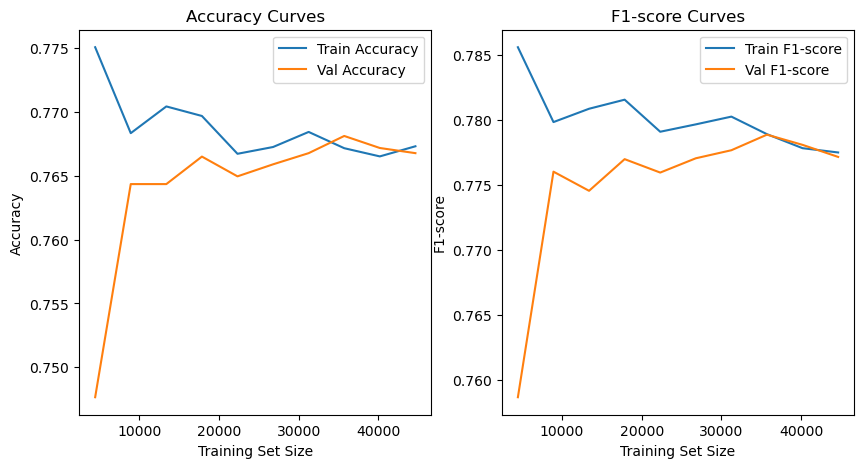

In [404]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes = (train_sizes * X_train.shape[0]).astype(int) 

train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []

for train_size in train_sizes:
    model.fit(X_train[:train_size], y_train[:train_size])

    y_train_pred_proba = model.predict_proba(X_train[:train_size])[:, 1]
    train_accuracy = model.score(X_train[:train_size], y_train[:train_size])
    train_f1 = f1_score(y_train[:train_size], (y_train_pred_proba > 0.5).astype(int))
    
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    val_accuracy = model.score(X_val, y_val)
    val_f1 = f1_score(y_val, (y_val_pred_proba > 0.5).astype(int))

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_sizes, train_accuracies, label='Train Accuracy')
plt.plot(train_sizes, val_accuracies, label='Val Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_sizes, train_f1_scores, label='Train F1-score')
plt.plot(train_sizes, val_f1_scores, label='Val F1-score')
plt.xlabel('Training Set Size')
plt.ylabel('F1-score')
plt.title('F1-score Curves')
plt.legend()

plt.show()